In [48]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import binarize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#stuff for multiprocessing
from multiprocessing import Pool
from functools import partial
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd") # weird warning

#### Set directory to save simulated data & results

In [49]:
wd = '/Users/steven/Desktop/confounds_sims/python'
if not os.path.exists(wd):
    os.makedirs(wd)

### Function to create data

In [50]:
def create_dat(n_obs, n_ind, corr_independent_confound, corr_indep_dependent, seed=None):
    '''
    Generates a dataset, with the following properties:
    
    1. brain_size is a vector of random Gaussian numbers, of size n_obs (every participant has 1 brain size)
    2. X is a np.ndarray of size (n_obs, n_ind) containing the independent variables ("voxels")
    3. The independent variables ("voxels") are correlated with brain_size.
    4. The independent variables ("voxels") are correlated with y
    5. y is a continuous dependent variable (e.g., 'intelligence')
    
    Parameters
    -------------
    n_obs : int
        Number of participants (observations)
    n_ind : int
        Number of independent variables ("voxels")
    corr_independent_confound : float
        Value determining the strength of the correlation between the independent variables ("voxels") and confound (brain_size). Higher = stronger correlations possible. Note that correlations are 'random'; not all independent variables correlate with brain size, and the sign of the correlation is random.
    corr_independent_dependent : float
        Value determining the strength of the correlation between the independent variables and the dependent variable.
    seed : int
        Seed for replicability
        
    Returns
    -------------
    data : dict
        Dictionary with three keys: X, y, and brain_size.
    '''
    if seed:
        np.random.seed(seed)
    
    brain_size = np.random.normal(size=n_obs) # simulate normalized brain size
    data = np.ndarray(shape=(n_obs, n_ind))   # empty ndarray

    # Generate n_ind independent variables. Each independent variable is the brain size multiplied by 
    # some random gaussian value (mean 0 std 1), with gaussian noise
    for x_i in np.arange(n_ind):
        bs_weight = np.abs(np.random.normal(0, corr_independent_confound))
#         print(bs_weight)
        data[:,x_i] = brain_size*bs_weight + np.random.normal(size=n_obs)
    
    # Weights (betas) that specify the relation between each independent var and the dep var. Also random normal (mean 0, std 1)
    weights = np.random.normal(0, corr_indep_dependent, size=n_ind)
    
    # y is defined as weights * data plus random noise
    y = np.dot(data, weights) + np.random.normal(size=n_obs)
    y = y.reshape(y.shape[0], 1)
    
    out = {'X':data, 'y':y, 'brain_size':brain_size, 'weights' : weights}
    return out

#### Function to 'regress out' or 'partial out' variance explained by a confound from all independent vars

In [51]:
def regress_out_confound(X, conf):
    '''
    Regresses out confounds from a matrix of independent vars
    '''
    
#     print(X)
    
    for x_i in np.arange(X.shape[1]):
        mod = LinearRegression().fit(X=conf.reshape(-1,1), y=X[:,x_i].reshape(-1,1))
        
        preds = mod.predict(conf.reshape(-1,1))
        preds = preds.reshape((preds.shape[0],))
        X[:,x_i] = X[:,x_i] - preds
        
#     print(X)
    return X

#### ML-routine

In [52]:
def learn_and_predict(X, y, n_splits=10):
    '''
    K-fold cross-validation routine: learns weights on train data, predicts & scores test data. 
    Returns a vector of n_folds accuracies. Defaults to 10 folds.
    '''
    
    folds = KFold(n_splits=n_splits)
    acc = np.ndarray(n_splits)

    for i, (train_idx, test_idx) in enumerate(folds.split(X)):
        X_train = X[train_idx,:]
        y_train = y[train_idx]
        X_test = X[test_idx,:]
        y_test = y[test_idx]

        mod = LogisticRegression().fit(X=X_train, y=y_train)
        acc[i] = mod.score(X=X_test, y=np.ravel(y_test))   
        
    return acc

### Process function for multiprocessing

In [53]:
def process(dataset_n, n_obs, n_ind, corr_independent_confound, corr_indep_dependent, verbose=False):
    
    # Generate data
    data = create_dat(120, n_ind, corr_independent_confound, corr_indep_dependent, dataset_n)
    
    # Regress out brain size from X
    X_noconfound = regress_out_confound(X=data['X'], conf=data['brain_size'])
    
    # Binarize y
    y2 = binarize(data['y'], threshold=np.median(data['y']))
    y2 = np.ravel(y2)
    
    # Perform K-fold crossvalidation
    mean_acc = np.mean(learn_and_predict(X=X_noconfound, y=y2, n_splits=10))
    
    if verbose:
        print('Settings: n_ind = %d, corr_independent_confound = %.2f, corr_indep_dependent = %.2f, dataset %d, accuracy: %.3f' %(n_ind, corr_independent_confound, corr_indep_dependent, dataset_n, mean_acc))

    return mean_acc

In [54]:
def plot_data(data, no_conf=[]):
    

    
    sns.set(context="paper", font="monospace")

    if isinstance(no_conf, np.ndarray):
        f, axes = plt.subplots(2,3)
        f.set_figheight(15)
        f.set_figwidth(15)
        
        df = pd.DataFrame(data['X'])
        
        sns.heatmap(df, ax=axes[0,0])
        axes[0,0].set_title('Raw data colorized')

        df['bs'] = data['brain_size']
        df['y'] = data['y']

        sns.heatmap(df.corr(), ax=axes[0,1])
        axes[0,1].set_title('Correlation matrix IVs, brain size, DV')

        sns.heatmap(pd.DataFrame(data['weights']).transpose(), ax=axes[0,2])
        axes[0,2].set_title('Weights colorized')
        
        # Plot data with confound removed
        df = pd.DataFrame(no_conf)

        sns.heatmap(df, ax=axes[1,0])
        axes[1,0].set_title('Data after removing confound, colorized')
        
        df['bs'] = data['brain_size']
        df['y'] = data['y']
        sns.heatmap(df.corr(), ax=axes[1,1])
        axes[1,1].set_title('Correlation matrix NC IVs, brain size, DV')

    else:
        # Set up the matplotlib figure
        f, (ax1, ax2) = plt.subplots(2)
    #     print(df.corr())
        sns.heatmap(df.corr(), ax=ax1)
        ax1.set_title('Correlation matrix IVs, brain size, DV')
    #     print(data['weights'])
        sns.heatmap(pd.DataFrame(data['weights']).transpose(), ax=ax2)
        ax2.set_title('Weights colorized')

    

#### Some minor visualisations
Checks & Balances for data generation:

What does the data look like when we colorcode them? How about the correlation matrix; and does to correlation between y and each independent variable correspond to the weights?

(bottom-left figure is empty still. Also, the correlations between y and brain size are currently very low; not sure if that's correct... need to check that)

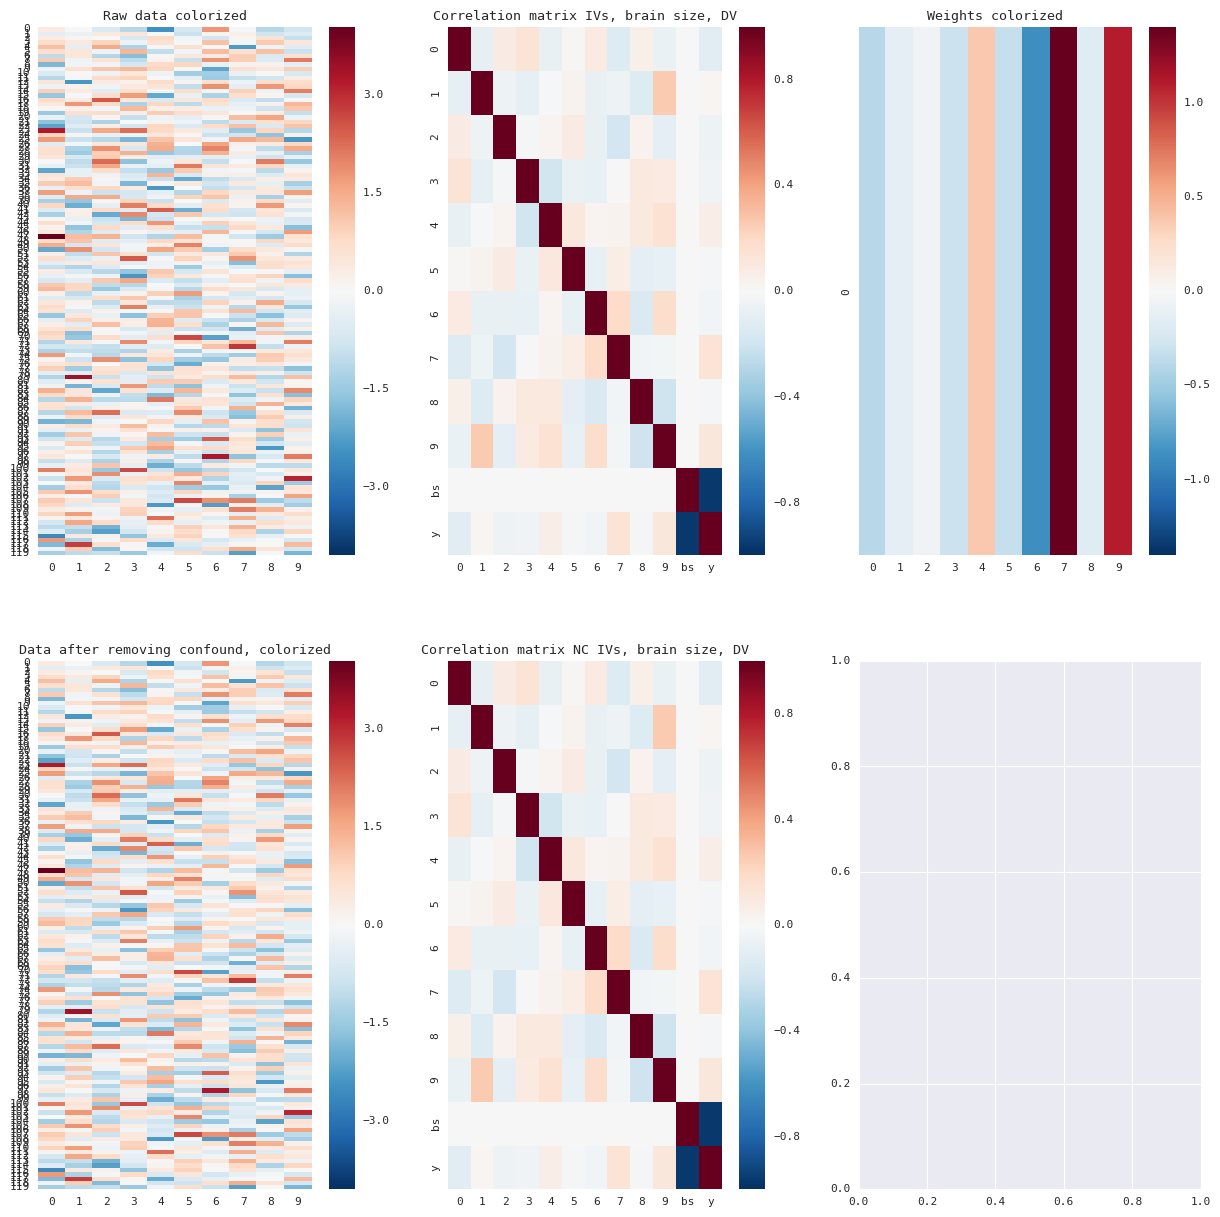

In [55]:
data = create_dat(120, 10, 10, 1, 2)
nc = regress_out_confound(data['X'], data['brain_size'])
plot_data(data, nc)

### Processing
Multiprocessed 'grid search'. For various numbers of IVs, various strengths of correlations between the IV and confound, various strengths of correlation between IVs&DV, do the following:
1. Generate 10 random data sets
2. Perform 10-fold cross-validation for each data set individually
3. Return mean accuracy over 10 folds per dataset
4. Average the 10 mean accuracies in a final "mean accuracy", which is returned and printed. If this value is below 0.5, we replicated the "below-chance accuracy"-issue.

In [ ]:
verbose=False

for n_ind in [100, 1000, 5000]:
    for corr_independent_confound in [.1, .5, 1, 2, 5, 10]:
        for corr_indep_dependent in [.1, .5, 1, 2, 5, 10]:
            
            n_datasets = 10
            p = Pool(8)
            res = p.map(partial(process, n_obs=120, n_ind=n_ind, corr_independent_confound=corr_independent_confound, corr_indep_dependent=corr_indep_dependent, verbose=verbose), np.arange(n_datasets))
            p.close()
            p.join()
            print('Settings: n_ind = %d, corr_independent_confound = %.2f, corr_indep_dependent = %.2f, mean accuracy: %.3f' %(n_ind, corr_independent_confound, corr_indep_dependent, np.mean(res)))

Settings: n_ind = 100, corr_independent_confound = 0.10, corr_indep_dependent = 0.10, mean accuracy: 0.622
Settings: n_ind = 100, corr_independent_confound = 0.10, corr_indep_dependent = 0.50, mean accuracy: 0.715
Settings: n_ind = 100, corr_independent_confound = 0.10, corr_indep_dependent = 1.00, mean accuracy: 0.725
Settings: n_ind = 100, corr_independent_confound = 0.10, corr_indep_dependent = 2.00, mean accuracy: 0.728
Settings: n_ind = 100, corr_independent_confound = 0.10, corr_indep_dependent = 5.00, mean accuracy: 0.712
Settings: n_ind = 100, corr_independent_confound = 0.10, corr_indep_dependent = 10.00, mean accuracy: 0.700
Settings: n_ind = 100, corr_independent_confound = 0.50, corr_indep_dependent = 0.10, mean accuracy: 0.515
Settings: n_ind = 100, corr_independent_confound = 0.50, corr_indep_dependent = 0.50, mean accuracy: 0.521
Settings: n_ind = 100, corr_independent_confound = 0.50, corr_indep_dependent = 1.00, mean accuracy: 0.540
Settings: n_ind = 100, corr_independ